In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import random

from xgboost import plot_importance
from xgboost import XGBRegressor
import statsmodels.api as sm

from sklearn.model_selection import train_test_split

In [2]:
df1 = pd.read_csv('../data/processed_data/merged_characteristics.csv')
df2 = pd.read_csv('../data/processed_data/merged_characteristics_2017.csv')
keys = ['HIOS ID', 'IssuerId', 'County', 'State', 'FIPS County Code', 'Policy County FIPS Code','County Name']


missing_cols = ['DP05_0028PE', 'Number of Consumers with CSR AV of 87%', 
                'Average Monthly Advanced CSR Payment for Consumers with 87%', 
                'DP05_0018PE', 'Number of Consumers with CSR (AV of 73%/87%/94%)', 'Total Number of Consumers',
                'Number of Consumers with CSR AV of 73%', 'Number of Consumers with CSR AV of 94%', 'FIPS County Code',
                'Average Monthly Advanced CSR Payment for Consumers with 73%', 
                'Average Monthly Advanced CSR Payment for Consumers with 94%', 
                'DP05_0032PE', 'DP05_0004PE', 'County Name']

#setup y
y_cols = ['Ever Enrolled Count']
    
x_cols = []
for col in df1.columns:
    if col not in y_cols and col not in keys and col not in missing_cols: 
        x_cols.append(col)

print(df1['Ever Enrolled Count'].var())

33292699.792409495


In [3]:
X_train = df1[x_cols]
X_train = X_train/X_train.std()

X_test = df2[x_cols]
X_test = X_test/X_test.std()
X_test = X_test.fillna(0)

y_train = df1[y_cols]
y_test = df2[y_cols]

In [4]:
def get_predictions(model,X_test):
    y_pred = model.predict(X_test)
    y_pred[y_pred < 0] = 0
    return np.array(y_pred).reshape(X_test.shape[0],1)


def plot_prediction(split,y_pred,y_test):
    #setup the data
    
    plt.hist(y_pred[y_test < split],label='predictions',alpha=.5,density=True)
    plt.hist(y_test[y_test < split],label='true',alpha=.5,density=True)
    plt.legend()
    plt.show()

    plt.hist(y_pred[y_pred > split],label='predictions',alpha=.5,density=True)
    plt.hist(y_test[y_pred > split],label='true',alpha=.5,density=True)
    plt.legend()
    plt.show()
    
    
def plot_importance(X_test,model):
    #use similar code for producing rankings of features according to LASSO
    cols = np.array(X_test.columns)
    importance_raw = model.get_booster().get_score(importance_type='weight')
    importance = []

    for key in importance_raw.keys():
        importance.append([key,importance_raw[key]])

    importance  = pd.DataFrame( importance, columns=['features','score'])
    importance = importance.sort_values('score',ascending=False)

    plt.barh(importance.head(20)['features'].iloc[::-1], importance.head(20)['score'].iloc[::-1])
    plt.show()

    
def report_error(y_test,y_pred):
    y_test = y_test.copy()
    y_test['error'] = np.abs(y_test - y_pred)**2
    y_test['pred'] = y_pred
    result = y_test.merge(df2, how='inner',left_index=True, right_index=True,suffixes=('','_x'))
    result  =  result.rename(columns={'Total Number of Consumers':'csr_tot',
                        'Number of Consumers with CSR AV of 94%':'csr_tot_94',
                                     'EHBPercentTotalPremium':'prices'})
    result['shares'] = result['Ever Enrolled Count']/result['DP03_0095E']
    result = result.sort_values('error',ascending=False).head(50)
    #plt.title('20 worst predictions')
    #plt.hist(result['Ever Enrolled Count'],label='true',alpha=.5,density=True)
    #plt.hist(result['pred'],label='pred',alpha=.5,density=True)
    #plt.legend()
    #plt.show()
    
    result_groupby = result.groupby('State')[['pred','Ever Enrolled Count','prices','csr_tot']].mean()
    #MetalLevel_Silver
    result_groupby = result.groupby('State')[['pred','Ever Enrolled Count']].mean()
    result_groupby[['pred_var','enroll_var']] = result.groupby('State')[['pred','Ever Enrolled Count']].std()
    result_groupby = result_groupby.sort_values('pred',ascending=False)
    return result_groupby

mse 49295356.545014545 r2 0.0046382222397460815


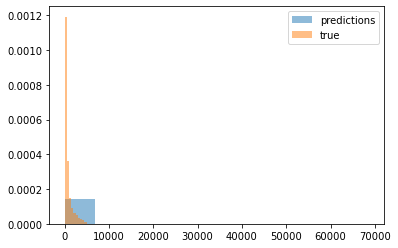

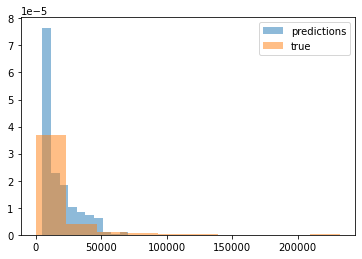

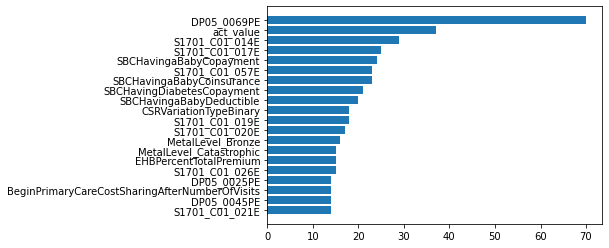

               pred  Ever Enrolled Count      pred_var    enroll_var
State                                                               
NV     52370.750000          2607.000000           NaN           NaN
AZ     48219.375000         51542.000000    796.807143  71539.407266
PA     46977.886719          5046.000000           NaN           NaN
NJ     45694.214844          5033.000000    666.867986   1040.861182
MI     45614.960938          2466.333333  12271.643918   1469.721833
MS     41314.703125           138.000000   3802.613109    195.161472
OK     38778.207031           219.000000           NaN           NaN
TX     38764.332031         11846.416667   7079.365897  32737.595621
FL     19609.349609         80016.111111  12247.656525  63699.526732
NC     10348.384766         55210.500000   1070.313146  14312.548358


In [5]:
# not super deep, but uses most of the data at one
model = XGBRegressor(n_estimators=X_train.shape[1], max_depth=2, eta=.5, subsample=0.9, colsample_bytree=.9)
model.fit(X_train, y_train)

y_pred = get_predictions(model,X_test)
mse = float( ((y_test - y_pred)**2).mean() )
r2 = float(  1- mse/y_test.var() ) 
print( 'mse', mse,'r2',  r2) 

#plot the difference between true and predicted
split = 5000
plot_prediction(split,y_pred,y_test)

plot_importance(X_test,model)

print(report_error(y_test,y_pred))

mse 49868446.65672015 r2 -0.006933496323303867


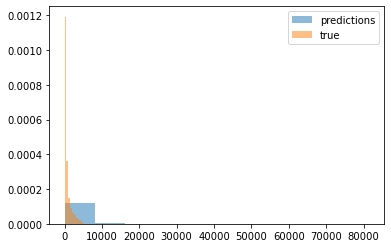

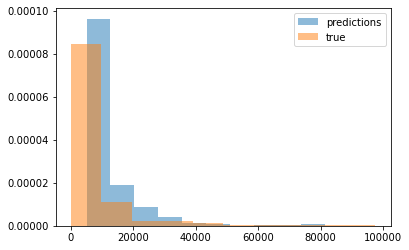

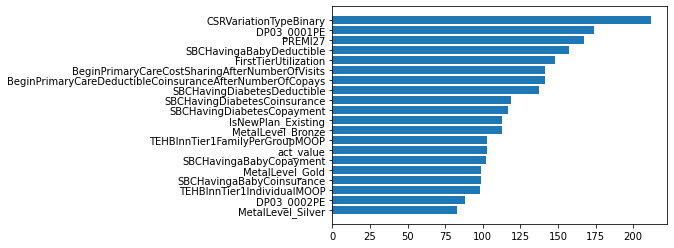

               pred  Ever Enrolled Count      pred_var    enroll_var
State                                                               
TX     44005.000000         36715.928571  33557.298251  37813.024456
VA     36440.070312          3909.000000   5700.921611   1609.905898
GA     29776.890625         15717.750000   3903.676486  24426.705323
PA     28153.445312         15046.000000  12671.634980  13830.898525
NJ     26609.890625           552.750000   3666.769636    313.564852
NV     24167.375000         47506.000000           NaN           NaN
MI     24007.710938            93.000000           NaN           NaN
FL     21055.212891         60099.583333  19073.453883  63475.346512
NC     19125.789062         65331.000000           NaN           NaN
MO     11378.989258         33361.000000           NaN           NaN
AZ         0.000000        102128.000000           NaN           NaN
IL         0.000000         76364.000000           NaN           NaN
UT         0.000000         35478.

In [6]:
#uses much less data, the covariates seem more accurate...
model = XGBRegressor(n_estimators=X_train.shape[1], max_depth=5, eta=.5, subsample=0.5, colsample_bytree=.9)
model.fit(X_train, y_train)

model.fit(X_train, y_train)

y_pred = get_predictions(model,X_test)
mse = float( ((y_test - y_pred)**2).mean() )
r2 = float(  1- mse/y_test.var() ) 
print( 'mse', mse,'r2',  r2) 

#plot the difference between true and predicted
split = 5000
plot_prediction(split,y_pred,y_test)

plot_importance(X_test,model)

print(report_error(y_test,y_pred))

alpha_value: 100 mse 34418232.357395135 r2 0.3050340772900437


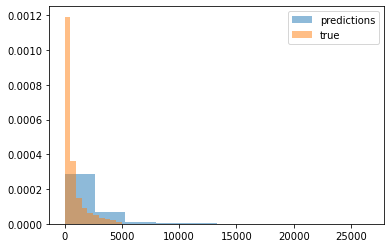

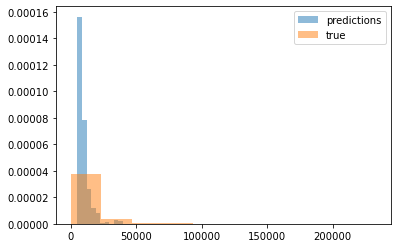

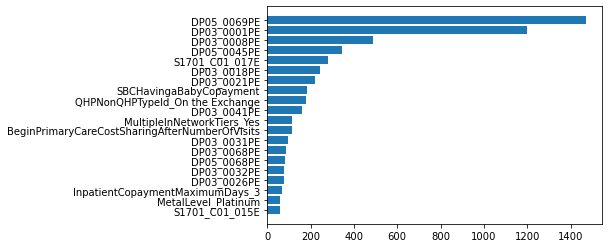

               pred  Ever Enrolled Count      pred_var    enroll_var
State                                                               
AZ     33024.553960        102128.000000           NaN           NaN
IL     29930.268781         41872.000000  16205.307980  30393.368833
NV     26596.649806         25056.500000     61.530739  31748.387368
TX     19414.057612         39540.615385   8427.459108  39475.362729
UT     19409.785355         40459.000000           NaN           NaN
NM     18536.962026             0.000000           NaN           NaN
FL     14503.300115         63854.285714   5010.588189  55078.932634
VA     12148.254364         35581.000000           NaN           NaN
PA     11337.917785         36763.000000   2322.610816   7968.287332
GA      9406.805597         36800.000000   2201.296923  13393.341368
MO      8077.117717         33361.000000           NaN           NaN
NC      7801.447069         40277.250000   3831.447977  19389.082622
KS      7704.109858         26915.

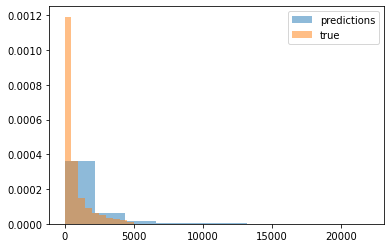

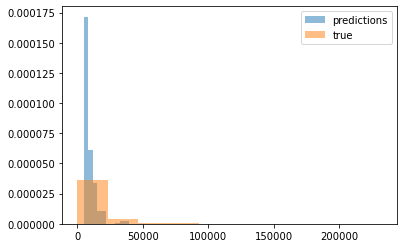

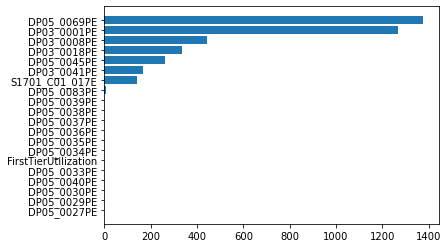

               pred  Ever Enrolled Count      pred_var    enroll_var
State                                                               
AZ     31312.323875        102128.000000           NaN           NaN
IL     29332.721072         41872.000000  16934.173824  30393.368833
NV     21606.887711         25056.500000      0.000000  31748.387368
TX     17782.205473         42825.166667   8517.568777  39331.550971
FL     12422.327155         63285.533333   4972.523331  52147.080269
VA     11968.327069         35581.000000           NaN           NaN
UT     10237.518902         32991.500000   6429.856679  10560.639777
PA      8937.197428         33730.000000   3069.618804   8895.247308
GA      8791.413698         36800.000000   1700.709074  13393.341368
NC      8389.232234         46566.333333   2795.727118  18071.783872
MO      7808.908790         33361.000000           NaN           NaN
OK      6637.658265         29752.500000    515.520094   4468.207750
KS      5591.433937         26915.

In [7]:
# Vary alpha values
a = [100,250]#[50,100,150,200,250]
for i in a: 
    lasso = sm.OLS(y_train, X_train).fit_regularized(method='elastic_net', alpha=i, L1_wt=1.0)
    y_pred = get_predictions(lasso,np.array(X_test))
    
    mse = float(((y_test - y_pred)**2).mean())
    r2 = float( 1 - mse/y_test.var() )
    print('alpha_value:', i, 'mse', mse, 'r2',r2 ) 
    
    #plot the difference between true and predicted
    split = 5000
    plot_prediction(split,y_pred,y_test)
    
    #also plot important feature
    param_df = pd.DataFrame(np.abs(lasso.params),columns=['score']).sort_values(by=['score'], ascending=False).head(20)
    param_df['features'] = param_df.index
    plt.barh(param_df['features'].iloc[::-1], param_df['score'].iloc[::-1])
    plt.show()
    print(report_error(y_test,y_pred))
    print('==========================================')
    print('==========================================')